In [1]:
import numpy as np
import pandas as pd

from pywarper.surface import fit_surface, build_sac_mapping
from pywarper.arbor import warp_arbor, get_zprofile, get_xyprofile
from pywarper.utils import read_arbor_trace
from pywarper.stats import get_convex_hull, get_hull_centroid, get_xy_center_of_mass


In [2]:
def read_ChAT(filename):
    
    df = pd.read_csv(filename, comment='#', sep=r'\s+')
    x = df["X"].values.astype(float)
    y = df["Slice"].values.astype(float)
    z = df["Y"].values.astype(float)

    x = x + 1
    z = z + 1

    return x, y ,z

# data from Sümbül et al. 2014
# https://github.com/uygarsumbul/rgc
chat_top = read_ChAT("../tests/data/Image013-009_01_ChAT-TopBand-Mike.txt") # should be the off sac layer
chat_bottom = read_ChAT("../tests/data/Image013-009_01_ChAT-BottomBand-Mike.txt") # should be the on sac layer
# but the image can be flipped
if chat_top[2].mean() > chat_bottom[2].mean():
    off_sac = chat_top
    on_sac = chat_bottom
else:
    off_sac = chat_bottom
    on_sac = chat_top

rgc, nodes, edges, radii = read_arbor_trace("../tests/data/Image013-009_01_raw_latest_Uygar.swc")
nodes += 1 # to match the matlab code

In [3]:
# Fit surfaces with pygridfit under the hood
thisvzmaxmesh, xgridmax, ygridmax = fit_surface(x=off_sac[0], y=off_sac[1], z=off_sac[2], smoothness=15)
thisvzminmesh, xgridmin, ygridmin = fit_surface(x=on_sac[0], y=on_sac[1], z=on_sac[2], smoothness=15)

In [4]:
# fit quasi-conformally mapping
arbor_boundaries = np.array([nodes[:, 0].min(), nodes[:, 0].max(), nodes[:, 1].min(), nodes[:, 1].max()])
surface_mapping = build_sac_mapping(thisvzminmesh, thisvzmaxmesh, arbor_boundaries, conformal_jump=2, verbose=True)

Mapping ON (min) surface …
Completed in 0.85 seconds.
Mapping OFF (max) surface …
Completed in 0.77 seconds.


In [5]:
# warp the arbor

# up until this point, all computation were done in the original coordinate system
# only the warped arbor will be in physical units, if we provide the voxel resolution
warped_arbor = warp_arbor(nodes, edges, radii, surface_mapping, voxel_resolution=[0.4, 0.4, 0.5], conformal_jump=2, verbose=True)
warped_nodes = warped_arbor["nodes"]

Warping nodes...
Nodes warped in 1.21 seconds.


In [6]:
# basically the same as the tests
import scipy.io
warped_arbor_mat = scipy.io.loadmat("../tests/data/warpedArbor_jump.mat", squeeze_me=True, struct_as_record=False)["warpedArbor"]
warped_arbor_mat = {
    "nodes": warped_arbor_mat.nodes,
    "edges": warped_arbor_mat.edges,
    "radii": warped_arbor_mat.radii,
    "medVZmin": warped_arbor_mat.medVZmin,
    "medVZmax": warped_arbor_mat.medVZmax
}

np.allclose(warped_nodes, warped_arbor_mat["nodes"]),\
np.isclose(warped_arbor["medVZmin"], warped_arbor_mat["medVZmin"]),\
np.isclose(warped_arbor["medVZmax"], warped_arbor_mat["medVZmax"])

(True, np.True_, np.True_)

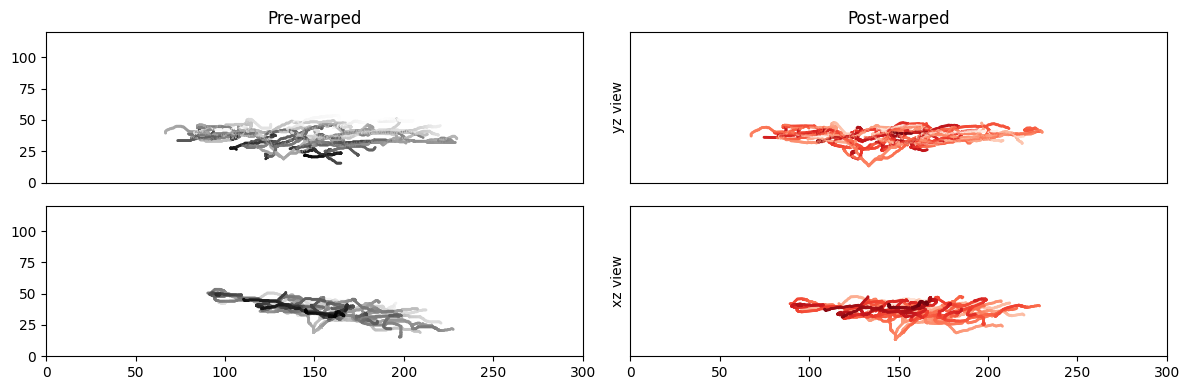

In [7]:
import matplotlib.pyplot as plt
mosaic = """
AB
CD
"""
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(12, 4))

depth_order_pre = np.argsort(nodes[:, 1])  # ascending (far → near)
sorted_nodes_pre = nodes[depth_order_pre] * [0.4, 0.4, 0.5]  # scale to match the warped nodes

# Sort nodes for post-warped plot by depth (y-axis)
depth_order_post = np.argsort(warped_nodes[:, 1])
sorted_nodes_post = warped_nodes[depth_order_post]

# pre-warped
ax["A"].scatter(sorted_nodes_pre[:, 1], sorted_nodes_pre[:, 2], c=sorted_nodes_pre[:, 0], s=1, alpha=1, cmap="Grays")
ax["C"].scatter(sorted_nodes_pre[:, 0], sorted_nodes_pre[:, 2], c=sorted_nodes_pre[:, 1], s=1, alpha=1, cmap="Grays")
ax["A"].set_title("Pre-warped")

# post-warped
ax["B"].scatter(sorted_nodes_post[:, 1], sorted_nodes_post[:, 2], c=sorted_nodes_post[:, 0], s=1, alpha=1, cmap="Reds")
ax["D"].scatter(sorted_nodes_post[:, 0], sorted_nodes_post[:, 2], c=sorted_nodes_post[:, 1], s=1, alpha=1, cmap="Reds")

ax["B"].set_ylabel("yz view")
ax["D"].set_ylabel("xz view")

ax["B"].set_title("Post-warped")

for i in ["A", "B", "C", "D"]:

    if i not in ['C', 'D']:
        ax[i].set_xticks([])

    if i not in ['A', 'C']:
        ax[i].set_yticks([])

    ax[i].set_ylim(0, 120)
    ax[i].set_xlim(0, 300)

fig.tight_layout()

In [8]:
# z resolution (z_res) is needed to compute the z-profile, as the surface mapping is still in voxel units
x, z_dist, z_hist, normed_arbor = get_zprofile(warped_arbor, z_res=0.5, z_window=[-30, 30], nbins=120)

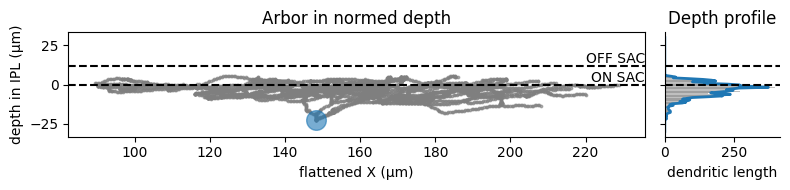

In [9]:
fig, (ax_nodes, ax_prof) = plt.subplots(
    1, 2,
    figsize=(8, 2),
    sharey=True,                 # align the y-axes
    gridspec_kw={'width_ratios': [5, 1]}
)

# --- left: flattened arbor ----------------------------------------
ax_nodes.scatter(
    normed_arbor['nodes'][:, 0],   # flattened X in µm
    normed_arbor['nodes'][:, 2],   # depth (0…12 µm)
    s=3,  c='tab:gray', alpha=0.6
)
ax_nodes.set_xlabel('flattened X (µm)')
ax_nodes.set_ylabel('depth in IPL (µm)')
ax_nodes.set_title('Arbor in normed depth')

# guide lines at ON / OFF SAC
for y in (0, 12):
    ax_nodes.axhline(y, ls='--', c='k')
ax_nodes.text(ax_nodes.get_xlim()[1], 0,
              'ON SAC', va='bottom', ha='right', fontsize=10)
ax_nodes.text(ax_nodes.get_xlim()[1], 12,
              'OFF SAC', va='bottom', ha='right', fontsize=10)

ax_nodes.scatter(
    normed_arbor['nodes'][0, 0],   
    normed_arbor['nodes'][0, 2],  
    s=200,  c='tab:blue', alpha=0.6
)

# --- right: depth profile (horizontal) ----------------------------
ax_prof.plot(z_dist, x, lw=2, c='tab:blue')
ax_prof.barh(x, z_hist, color="gray", alpha=0.5)
ax_prof.set_xlabel('dendritic length')
ax_prof.set_title('Depth profile')
ax_prof.axhline(0,  ls='--', c='k')
ax_prof.axhline(12, ls='--', c='k')

# remove unneeded spines to tidy the small panel
ax_prof.spines['top'].set_visible(False)
ax_prof.spines['right'].set_visible(False)

fig.tight_layout()
plt.show()

In [10]:
xy_x, xy_y, xy_dist, xy_hist = get_xyprofile(
    warped_arbor, xy_window=[50, 250, 50, 250], nbins=20, sigma_bins=1
)

hull = get_convex_hull(normed_arbor['nodes'][:, 0:2])
com_hull = get_hull_centroid(hull)

com_xy = get_xy_center_of_mass(xy_x, xy_y, xy_dist)

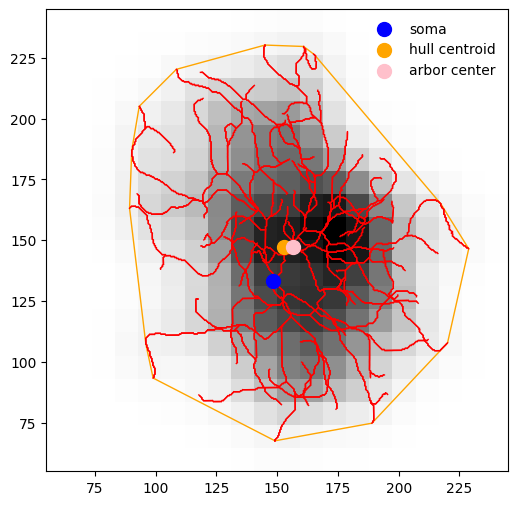

In [11]:
from matplotlib.colors import Normalize
fig, ax = plt.subplots(figsize=(6, 6))

im = ax.imshow(
    xy_dist.T, origin="lower",
    extent=[xy_x[0], xy_x[-1], xy_y[0], xy_y[-1]],
    cmap="Greys", norm=Normalize(vmin=0, vmax=xy_dist.max()),
)

for c, p in warped_arbor["edges"]:
    if p == -1:          # skip soma parent
        continue
    ax.plot(
        [warped_arbor["nodes"][c-1, 0], warped_arbor["nodes"][p-1, 0]],
        [warped_arbor["nodes"][c-1, 1], warped_arbor["nodes"][p-1, 1]],
        lw=1, color='red',
    )

ax.scatter(
    warped_arbor["nodes"][0, 0],
    warped_arbor["nodes"][0, 1],
    s=100, color='blue', zorder=99, label='soma',
)

ax.scatter(
    com_hull[0], com_hull[1],
    s=100, color='orange', zorder=99, label='hull centroid'
)

ax.scatter(
    com_xy[0], com_xy[1],
    s=100, color='pink', zorder=99, label='arbor center'
)

plt.fill(hull[:, 0], hull[:, 1], facecolor="none", edgecolor="orange", linewidth=1)

ax.legend(frameon=False)

In [12]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-05-30 22:24:56CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.1.0

numpy     : 2.2.4
pandas    : 2.2.3
matplotlib: 3.10.3
pywarper  : 0.1.5
scipy     : 1.15.2

Watermark: 2.5.0

